## Import Liberies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Remove Unnecessary Files

In [2]:
data_dir = 'data'

# Remove macOS system file if present (can break dataset loading)
if '.DS_Store' in os.listdir(data_dir):
    os.remove(os.path.join(data_dir, '.DS_Store'))

## Load Data

In [ ]:
image_size = 224
input_size = (image_size, image_size)

# Load training dataset from directory with 80/20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,  # Ensures same split every run
    label_mode='categorical',  # One-hot encode class labels
    image_size=input_size,
    batch_size=32
)

# Load validation dataset from same directory with consistent split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=input_size,
    batch_size=32
)


## Check Classes

2025-04-09 12:43:00.154529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


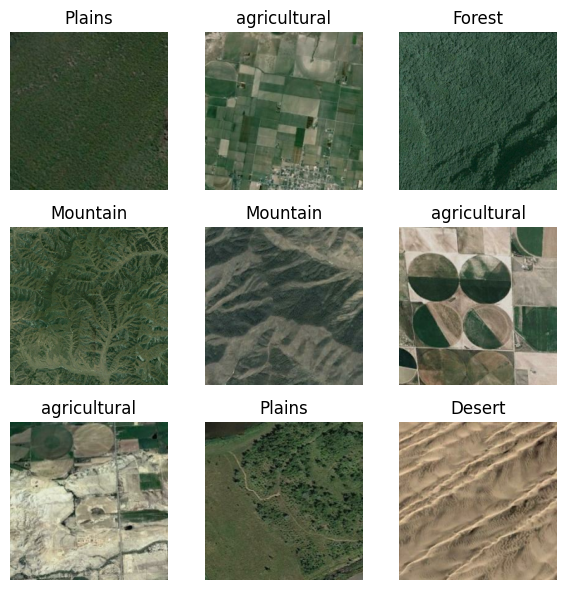

In [ ]:
# Get the list of class names from the dataset
class_names = train_ds.class_names

# Display a 3x3 grid of sample images with labels
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):  # Take one batch from the training set
    for i in range(9):  # Show the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Decode one-hot label to class index, then get class name
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

plt.tight_layout()
plt.show()


## Build Model

In [5]:
# Build a classification model using ResNet50 as a frozen feature extractor
resnet_model = Sequential()

# Load pre-trained ResNet50 without top layers (we'll add our own)
pretrained_model = ResNet50(
    include_top=False,  # Exclude original classification head
    input_shape=(image_size, image_size, 3),
    pooling='avg',      # Global average pooling after the last conv block
    weights='imagenet'  # Use ImageNet-pretrained weights
)

# Freeze all layers in the pre-trained base model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add pre-trained base to our model
resnet_model.add(pretrained_model)

# Add custom classification head
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(len(class_names), activation='softmax'))  # One output per class

# Print model architecture summary
resnet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile Model

In [6]:
# Stop training early if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True  # Roll back to best weights after stopping
)

# Compile the model with a low learning rate and categorical loss
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning pretrained layers
    loss='categorical_crossentropy',    # Use categorical loss for one-hot labels
    metrics=['accuracy']
)


## Train Model

In [7]:
# Train the model using GPU (if available), with early stopping
with tf.device('/GPU:0'):
    history = resnet_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=200,
        callbacks=[early_stopping]
    )


Epoch 1/200


2025-04-08 19:23:35.471220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


133/133 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 0.4028 - loss: 1.5604 - val_accuracy: 0.8329 - val_loss: 0.5857
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.8678 - loss: 0.4913 - val_accuracy: 0.9131 - val_loss: 0.3275
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.9239 - loss: 0.2956 - val_accuracy: 0.9415 - val_loss: 0.2353
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.9410 - loss: 0.2185 - val_accuracy: 0.9509 - val_loss: 0.1875
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 242ms/step - accuracy: 0.9529 - loss: 0.1717 - val_accuracy: 0.9632 - val_loss: 0.1580
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.9592 - loss: 0.1473 - val_accuracy: 0.9660 - val_loss: 0.1383
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.9652 - loss: 0.1300 - val_accuracy: 0.9669 - val_loss: 0.1240
Epoch 8/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - accuracy: 0.9695 - loss: 0.110

## Evaluating The Model

In [8]:
# Evaluate model performance on the training set
train_loss, train_accuracy = resnet_model.evaluate(train_ds)

# Evaluate model performance on the validation set
val_loss, val_accuracy = resnet_model.evaluate(val_ds)


133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.9981 - loss: 0.0104
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9748 - loss: 0.0592


## Loss Plot

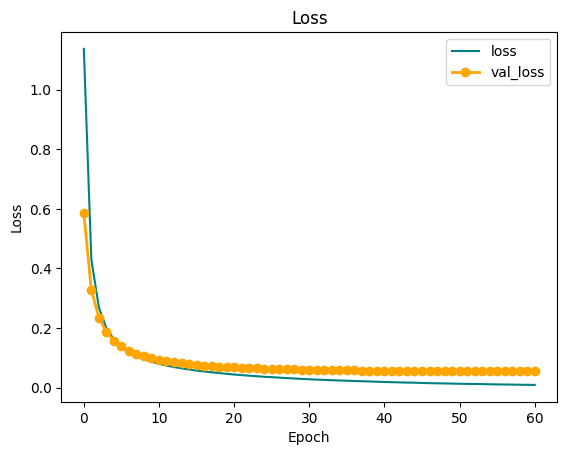

Train Loss: 0.0104 | Val Loss: 0.0555
Train Accuracy: 99.81% | Val Accuracy: 97.92%


In [54]:
# Plot training and validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], '-o', color='orange', label='val_loss', linewidth=2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print final loss and accuracy values
print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.2%} | Val Accuracy: {val_accuracy:.2%}")



## Accuracy Plot

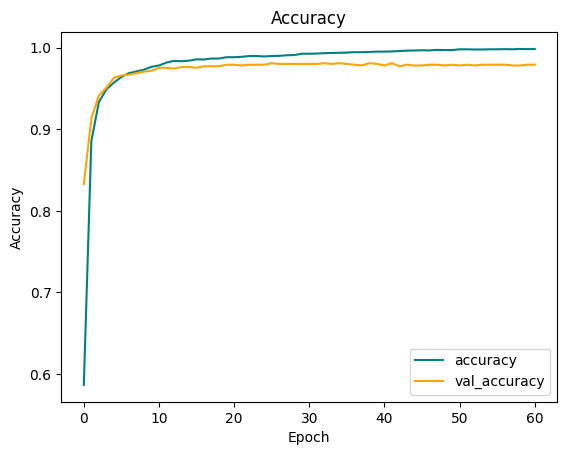

In [ ]:
# Plot training and validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix

Confusion Matrix:


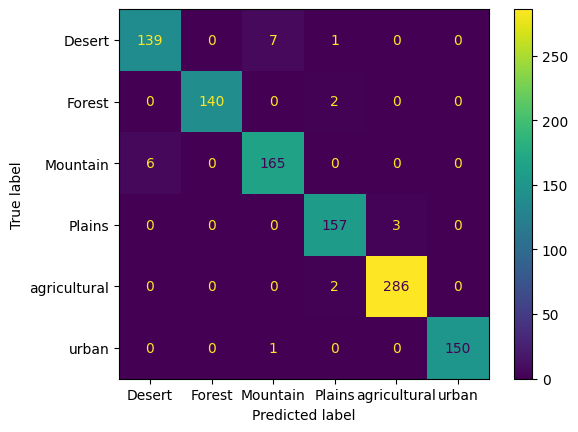

In [ ]:
# Collect ground truth labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))           # Convert one-hot to class index
    y_pred_probs.extend(resnet_model.predict(images))          # Get predicted probabilities

# Convert predicted probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")

# Visualize the confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="viridis")  # You can change to 'Blues', 'magma', etc.
plt.show()

## Test Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


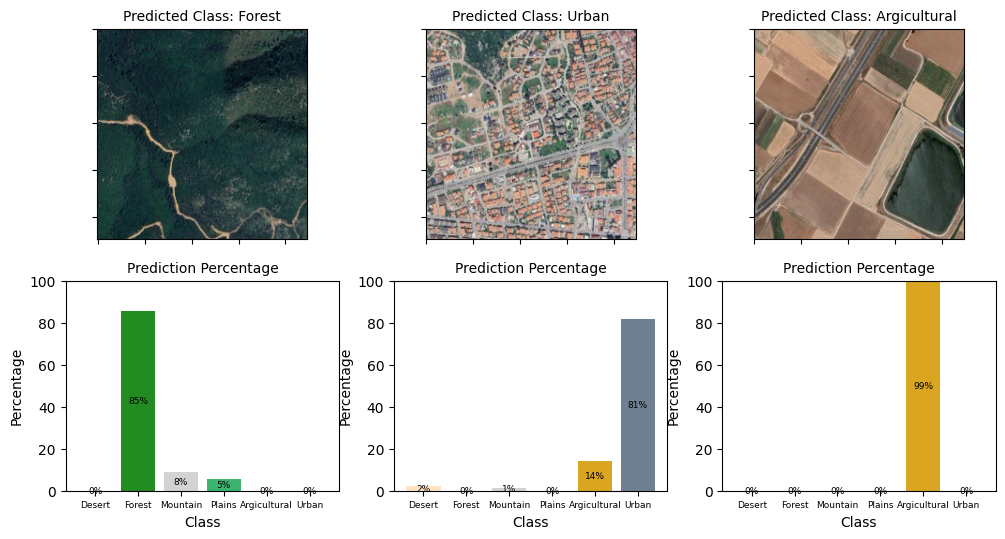

In [32]:
# Define class labels and their corresponding bar colors
class_labels = ['Desert', 'Forest', 'Mountain', 'Plains', 'Argicultural', 'Urban']
color_class = ['bisque', 'forestgreen', 'lightgray', 'mediumseagreen', 'goldenrod', 'slategray']

# List of image filenames to visualize
images = ['your_fig_name_1.png', 'your_fig_name_2.png', 'your_fig_name_3.png']
num_fig = len(images)

# Font and bar size settings
f_size = 10
bar_size = 6.5

# Create a 2-row plot layout: image on top, probability bars below
fig, ax = plt.subplots(ncols=num_fig, nrows=2, figsize=(12, 6))  

for i in range(num_fig):
    # Load and preprocess the image
    img = cv2.imread(f'images/your_folder/{images[i]}')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resize = tf.image.resize(img_rgb, (224, 224))
    
    # Predict class probabilities using the trained model
    yhat = resnet_model.predict(np.expand_dims(resize, 0))
    yhat_class = np.argmax(yhat, axis=1)

    # Convert probabilities to percentages
    perc = yhat[0] * 100

    # Display the input image with predicted label
    ax[0, i].imshow(resize.numpy().astype(int))
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Predicted Class: {class_labels[yhat_class[0]]}', fontsize=f_size)

    # Plot the prediction percentages as a bar chart
    bars = ax[1, i].bar(class_labels, perc, color=color_class)
    ax[1, i].bar_label(bars, labels=[f'{int(p)}%' for p in perc], 
                       label_type='center', color='black', fontsize=bar_size)
    
    ax[1, i].tick_params(axis='x', labelsize=bar_size)
    ax[1, i].set_title('Prediction Percentage', fontsize=f_size)
    ax[1, i].set_ylim(0, 100)
    ax[1, i].set_ylabel('Percentage', fontsize=f_size)
    ax[1, i].set_xlabel('Class', fontsize=f_size)

plt.tight_layout()
plt.show()


## Save Model

In [ ]:
resnet_model.save('models/model_name.h5')